# CBCT calibration development notebook

## Load needed modules

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import label
from skimage.morphology import dilation
from skimage.measure import regionprops
from skimage.measure import EllipseModel
import cv2
from scipy.signal import savgol_filter
from scipy.signal import medfilt


import sys
sys.path.append('../../scripts/python/')
import amglib.readers as io

sys.path.append('../')
import cbct.CBCT_Calibration as cbct

import importlib

## Load the data


In [73]:

#datapath = '/Users/Shared/data/P20240130_1/02_rawdata/00_setup/cbct-cal/'
datapath = '/Users/Shared/Data/P20240126_1_DinoCalibration/02_rawdata/00_Calibration/'
dc=io.read_images(datapath+'dc_{:05}.fits',first=1,last=5,averageStack=True,average='mean');
ob=io.read_images(datapath+'ob_{:05}.fits',first=1,last=5,averageStack=True,average='mean');
proj=io.read_images(datapath+'cal_{:05}.fits',first=1,last=360,stride=10)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

## Data preparation
- Create an instance of the CBCT_Calibration class
- Set the dark current and open beam images
- Set the calibration images
- Normalize
- Threshold

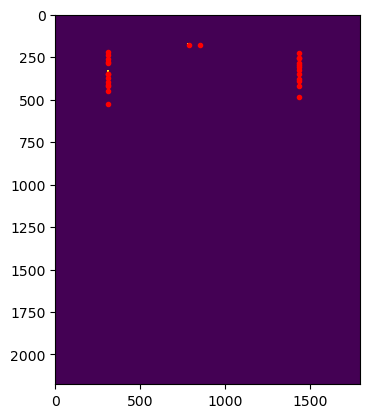

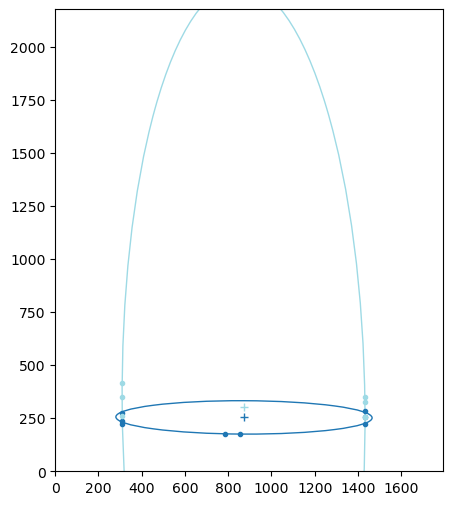

In [4]:
importlib.reload(cbct)  
cal = cbct.CBCTCalibration()
cal.set_projections(proj=proj,ob=ob,dc=dc,verticalflip=True,show=False)
cal.threshold_projections(threshold=0.15, show=False,clearborder=True)
cal.find_beads(show=True)
cal.find_trajectories(show=False)
cal.fit_ellipses(show=True,prune=True)
e=cal.ellipses

In [74]:
importlib.reload(cbct)  
cal = cbct.CBCTCalibration()
cal.set_projections(proj=proj,ob=ob,dc=dc,verticalflip=True,show=False)


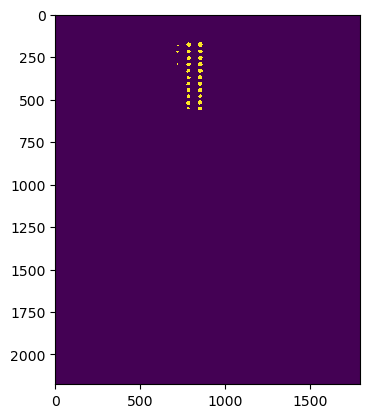

In [31]:

cal.threshold_projections(threshold=0.1, show=True,clearborder=False)


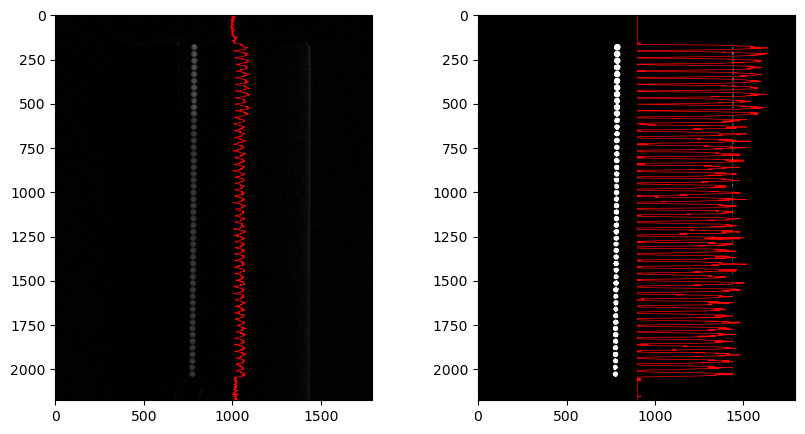

In [36]:
fig,ax=plt.subplots(1,2, figsize=(10,5))    
idx = 1
th = 0.07
ax[0].imshow(cal.projections_flat[idx],cmap='gray',vmin=0,vmax=0.4)
ax[0].plot(cal.projections_flat[idx].sum(axis=1)*20+900,np.arange(0,cal.projections_flat[0].shape[0]),'r',lw=0.5)

b = cal.projections_flat[idx]>th
ax[1].imshow(b,cmap='gray',vmin=0,vmax=0.4)
ax[1].plot(b.sum(axis=1)*20+900,np.arange(0,cal.projections_flat[0].shape[0]),'r',lw=0.5)

## Flatten

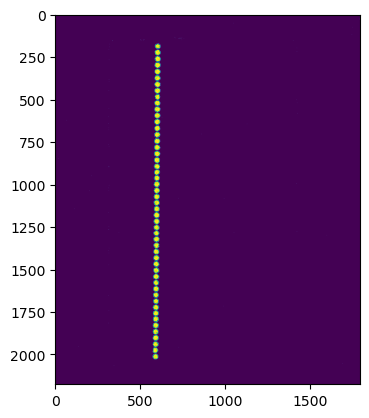

In [124]:
x=f[idx]-10*m
plt.imshow(x<0,cmap='viridis')

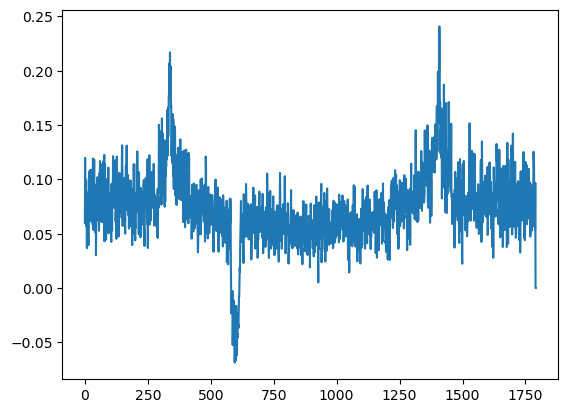

In [123]:
plt.plot(x[1000])

In [131]:
def flatten_projections(proj,amplication=10,stack_window=5):
    """ Detrends the projection of the cylinder 

    Arguments:
    - proj: a stack of projections
    - amplication: the amplification factor of the median correction to remove the edge effect of the cylinder
    - stack_window: the window size for the max operation in the stack direction
    """
    d = dilation(proj,footprint=np.ones((stack_window,1,1)))
    f = proj-d
    m=np.median(f,axis=0)
    #flatten projection
    for i in range(proj.shape[0]):
        f[i] = f[i] - amplication*m
        
    return f

In [132]:
fp = flatten_projections(cal.projections)   
plt.imshow(medfilt((fp[8]<0).astype(int),kernel_size=(5,5)),interpolation='none')



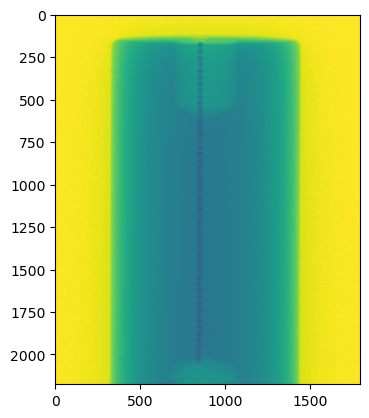

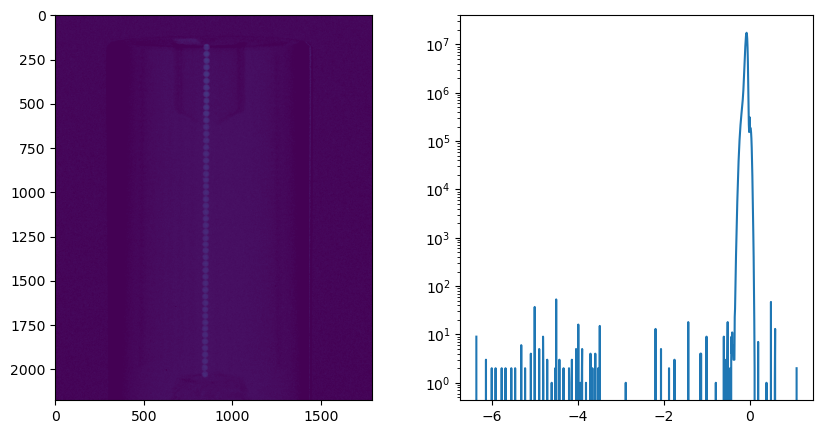

In [151]:
importlib.reload(cbct)

cal = cbct.CBCTCalibration()
cal.set_projections(proj=proj,ob=ob,dc=dc,verticalflip=True,show=True)

## COR

In [65]:
importlib.reload(cbct)

cal = cbct.CBCTCalibration()
cal.ellipses=e
cal.compute_calibration(avgtype='median', remove_outliers=True,show=True)
#cal._compute_piercing_point2(degree=3, show=True)

cal.calibration


TypeError: expected non-empty vector for x